In [1]:
import os 
import glob
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread,imsave
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import save_model, load_model, Model
from tensorflow.keras.layers import Input,InputLayer, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D
from sklearn.metrics import classification_report

In [2]:
root='AFFINE_REG_SKS_MASK_2D_IMAGES_DIR/'

In [3]:
def inceptionv3_row(optimizer, loss, metrics, shape, num_layers_trainable=1):
    # Load the base InceptionV3 model without the top layer
    base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=shape)

    # Freeze all layers except for the last num_layers_trainable layers
    for layer in base_model.layers[:-num_layers_trainable]:
        layer.trainable = False

    # Renaming the trainable layers to avoid naming conflicts
    for layer in base_model.layers[-num_layers_trainable:]:
        layer.trainable = True
        layer._name = layer._name + str('_ft')

    # Replace GlobalAveragePooling2D with Flatten layer
    y = tf.keras.layers.Flatten()(base_model.output)
    c = tf.keras.layers.Dropout(0.4)(y)
    c = tf.keras.layers.Dense(512, activation='relu')(c)
    c = tf.keras.layers.Dense(256, activation='relu')(c)
    c = tf.keras.layers.Dense(128, activation='relu')(c)
    output_layer = tf.keras.layers.Dense(3, activation='softmax')(c)

    # Create the new model
    model = tf.keras.Model(inputs=base_model.input, outputs=output_layer)

    # Compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model


In [4]:
def plot_confusion_matrix(true_lab,predict_lab,classes,path):
  matrix_confusion = tf.math.confusion_matrix(labels=true_lab, predictions=predicted_lab, num_classes=len(classes))
  ax = plt.subplot()
  sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(classes)
  ax.yaxis.set_ticklabels(classes)
  plt.savefig(f'{path}confusion_matrix.png')

In [5]:
def dump_text(text,path):
  text_file = open(path, "w")
  text_file.write(text)
  text_file.close()

In [6]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

2024-04-25 15:37:15.920085: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 15:37:17.572162: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9629 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:61:00.0, compute capability: 7.5


In [7]:
image_Shape=(436,364,3)
training_image_datagen = ImageDataGenerator(horizontal_flip=True).flow_from_directory(
                                                  directory=f'{root}/training/',
                                                  target_size=(image_Shape[0], image_Shape[1]),
                                                  class_mode='categorical',
                                                  batch_size=10
                                                  )

testing_image_datagen = ImageDataGenerator().flow_from_directory(
                                                  directory = f'{root}/testing/' ,
                                                  target_size = (image_Shape[0] ,image_Shape[1]) ,
                                                  class_mode = 'categorical' ,
                                                  batch_size=1 ,
                                                  shuffle = False
                                                  )

Found 11059 images belonging to 3 classes.
Found 494 images belonging to 3 classes.


In [8]:
EPOCH = 100
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='Accuracy'),
    tf.keras.metrics.Precision(name='AD_Precision',class_id=0),
    tf.keras.metrics.Precision(name='CN_Precision',class_id=1),
    tf.keras.metrics.Precision(name='MCI_Precision',class_id=2),
    tf.keras.metrics.Recall(name='AD_Recall',class_id=0),
    tf.keras.metrics.Recall(name='CN_Recall',class_id=1),
    tf.keras.metrics.Recall(name='MCI_Recall',class_id=2),
    ]
LOOS = 'categorical_crossentropy'

2024-04-25 15:37:24.141301: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9629 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:61:00.0, compute capability: 7.5


Epoch 1/50


2024-04-24 11:36:19.957896: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


2765/2765 [==============================] - 126s 43ms/step - loss: 3.6426 - Accuracy: 0.3876 - AD_Precision: 0.1905 - CN_Precision: 0.2852 - MCI_Precision: 0.5242 - AD_Recall: 0.1839 - CN_Recall: 0.2842 - MCI_Recall: 0.5034 - val_loss: 1.3599 - val_Accuracy: 0.4636 - val_AD_Precision: 0.1786 - val_CN_Precision: 1.0000 - val_MCI_Precision: 0.4812 - val_AD_Recall: 0.0510 - val_CN_Recall: 0.0127 - val_MCI_Recall: 0.9079
Epoch 2/50
2765/2765 [==============================] - 95s 34ms/step - loss: 2.9367 - Accuracy: 0.3906 - AD_Precision: 0.1793 - CN_Precision: 0.2881 - MCI_Precision: 0.5101 - AD_Recall: 0.1576 - CN_Recall: 0.2645 - MCI_Recall: 0.5194 - val_loss: 1.3639 - val_Accuracy: 0.4190 - val_AD_Precision: 0.1000 - val_CN_Precision: 1.0000 - val_MCI_Precision: 0.4799 - val_AD_Recall: 0.0612 - val_CN_Recall: 0.0127 - val_MCI_Recall: 0.6987
Epoch 3/50
2765/2765 [==============================] - 94s 34ms/step - loss: 2.5144 - Accuracy: 0.3999 - AD_Precision: 0.2045 - CN_Precision: 0.2

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/tensorflow/2.7.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/tensorflow/2.7.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


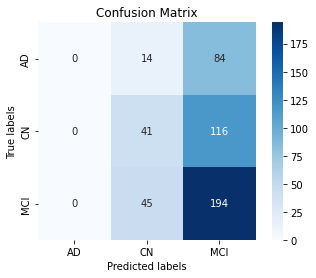

In [12]:
savepath = 'Augmentation training/Inception v3/Adam/Inceptionv3_50_0.000001/'
lr=0.000001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'inceptionv3_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model01 = inceptionv3_row(OPT, LOOS,METRICS,image_Shape)
history01 = model01.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model01 = inceptionv3_row(OPT, LOOS,METRICS,image_Shape)
model01.load_weights(glob.glob(f"{savepath}inceptionv3_row_10E-5_weights-epoch:*-val_Accuracy:{max(history01.history['val_Accuracy']):.4f}.h5")[0])
model01.save(f"{savepath}/inception_50_0.000001.h5")
p1 = model01.predict(testing_image_datagen)
predicted_lab = p1.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save(f"{savepath}/inception_50_0.000001.npy",p1) 

Epoch 1/70


2024-04-24 14:37:37.802358: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


1106/1106 [==============================] - 91s 77ms/step - loss: 2.3761 - Accuracy: 0.4055 - AD_Precision: 0.2017 - CN_Precision: 0.2959 - MCI_Precision: 0.5235 - AD_Recall: 0.1562 - CN_Recall: 0.2573 - MCI_Recall: 0.5296 - val_loss: 1.4168 - val_Accuracy: 0.5121 - val_AD_Precision: 0.0000e+00 - val_CN_Precision: 0.6038 - val_MCI_Precision: 0.5000 - val_AD_Recall: 0.0000e+00 - val_CN_Recall: 0.2038 - val_MCI_Recall: 0.9079
Epoch 2/70
1106/1106 [==============================] - 77s 70ms/step - loss: 1.3991 - Accuracy: 0.4354 - AD_Precision: 0.2339 - CN_Precision: 0.3219 - MCI_Precision: 0.5401 - AD_Recall: 0.1364 - CN_Recall: 0.2408 - MCI_Recall: 0.5541 - val_loss: 1.1282 - val_Accuracy: 0.4150 - val_AD_Precision: 0.0000e+00 - val_CN_Precision: 0.4143 - val_MCI_Precision: 0.5926 - val_AD_Recall: 0.0000e+00 - val_CN_Recall: 0.7389 - val_MCI_Recall: 0.1339
Epoch 3/70
1106/1106 [==============================] - 76s 69ms/step - loss: 1.2942 - Accuracy: 0.4399 - AD_Precision: 0.2346 - CN

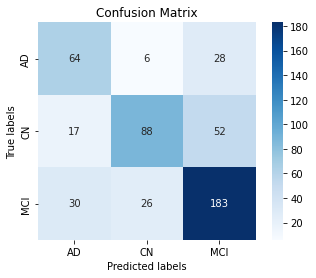

In [9]:
savepath = 'Augmentation training/Inception v3/Adam/Inception v3_70_0.00001/'
lr=0.00001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'inceptionv3_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.RMSprop(learning_rate=lr)
model05 = inceptionv3_row(OPT, LOOS,METRICS,image_Shape)
history05 = model05.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model05 = inceptionv3_row(OPT, LOOS,METRICS,image_Shape)
model05.load_weights(glob.glob(f"{savepath}inceptionv3_row_10E-5_weights-epoch:*-val_Accuracy:{max(history05.history['val_Accuracy']):.4f}.h5")[0])
model05.save(f"{savepath}/inceptionv3_0.00001.h5")
p = model05.predict(testing_image_datagen)
predicted_lab = p.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save(f"{savepath}/inceptionv3_0.00001.npy",p )

Epoch 1/100


2024-04-24 22:46:28.654507: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


1106/1106 [==============================] - 100s 82ms/step - loss: 11.1224 - Accuracy: 0.4027 - AD_Precision: 0.2027 - CN_Precision: 0.3073 - MCI_Precision: 0.5302 - AD_Recall: 0.1994 - CN_Recall: 0.3024 - MCI_Recall: 0.5255 - val_loss: 1.5267 - val_Accuracy: 0.3381 - val_AD_Precision: 0.0976 - val_CN_Precision: 0.3333 - val_MCI_Precision: 0.5333 - val_AD_Recall: 0.0408 - val_CN_Recall: 0.6433 - val_MCI_Recall: 0.2008
Epoch 2/100
1106/1106 [==============================] - 75s 67ms/step - loss: 1.9680 - Accuracy: 0.4038 - AD_Precision: 0.2020 - CN_Precision: 0.2851 - MCI_Precision: 0.5198 - AD_Recall: 0.1453 - CN_Recall: 0.2423 - MCI_Recall: 0.5201 - val_loss: 2.1519 - val_Accuracy: 0.4838 - val_AD_Precision: 0.0000e+00 - val_CN_Precision: 0.0000e+00 - val_MCI_Precision: 0.4838 - val_AD_Recall: 0.0000e+00 - val_CN_Recall: 0.0000e+00 - val_MCI_Recall: 1.0000
Epoch 3/100
1106/1106 [==============================] - 74s 67ms/step - loss: 1.3114 - Accuracy: 0.4469 - AD_Precision: 0.2104 

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/tensorflow/2.7.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/tensorflow/2.7.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


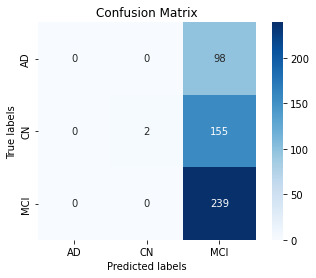

In [9]:
savepath = 'Augmentation training/Inception v3/Adam/Inceptionv3_100_0.0001/'
lr=0.0001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'inceptionv3_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.RMSprop(learning_rate=lr)
model05 = inceptionv3_row(OPT, LOOS,METRICS,image_Shape)
history05 = model05.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model05 = inceptionv3_row(OPT, LOOS,METRICS,image_Shape)
model05.load_weights(glob.glob(f"{savepath}inceptionv3_row_10E-5_weights-epoch:*-val_Accuracy:{max(history05.history['val_Accuracy']):.4f}.h5")[0])
model05.save(f"{savepath}/inceptionv3_100_0.0001.h5")
p = model05.predict(testing_image_datagen)
predicted_lab = p.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save(f"{savepath}/inceptionv3_100_0.0001.npy",p )

Epoch 1/100
1106/1106 [==============================] - 86s 75ms/step - loss: 8.6252 - Accuracy: 0.4385 - AD_Precision: 0.2010 - CN_Precision: 0.3151 - MCI_Precision: 0.5259 - AD_Recall: 0.1399 - CN_Recall: 0.2232 - MCI_Recall: 0.6634 - val_loss: 1.8446 - val_Accuracy: 0.3360 - val_AD_Precision: 0.2364 - val_CN_Precision: 0.4265 - val_MCI_Precision: 0.7692 - val_AD_Recall: 0.5306 - val_CN_Recall: 0.5732 - val_MCI_Recall: 0.0418
Epoch 2/100
1106/1106 [==============================] - 79s 71ms/step - loss: 1.8746 - Accuracy: 0.4319 - AD_Precision: 0.2354 - CN_Precision: 0.3436 - MCI_Precision: 0.5387 - AD_Recall: 0.1740 - CN_Recall: 0.2861 - MCI_Recall: 0.5468 - val_loss: 2.3976 - val_Accuracy: 0.4879 - val_AD_Precision: 0.3276 - val_CN_Precision: 0.0000e+00 - val_MCI_Precision: 0.5225 - val_AD_Recall: 0.1939 - val_CN_Recall: 0.0000e+00 - val_MCI_Recall: 0.8745
Epoch 3/100
1106/1106 [==============================] - 75s 68ms/step - loss: 1.5825 - Accuracy: 0.4351 - AD_Precision: 0.237

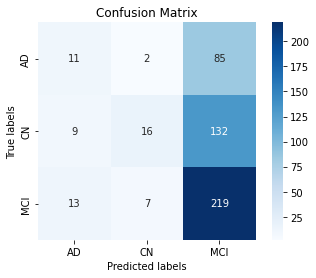

In [10]:
# learning_rate=10E-5
savepath = 'Augmentation training/Inception v3/Adam/Inceptionv3_100_0.0001/'
lr=0.0001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'inceptionv3_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model05 = inceptionv3_row(OPT, LOOS,METRICS,image_Shape)
history05 = model05.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model05 = inceptionv3_row(OPT, LOOS,METRICS,image_Shape)
model05.load_weights(glob.glob(f"{savepath}inceptionv3_row_10E-5_weights-epoch:*-val_Accuracy:{max(history05.history['val_Accuracy']):.4f}.h5")[0])
model05.save(f"{savepath}/inceptionv3_100_0.0001.h5")
p = model05.predict(testing_image_datagen)
predicted_lab = p.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save(f"{savepath}/inceptionv3_100_0.0001.npy",p )

Epoch 1/100


2024-04-25 15:37:37.810130: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


1106/1106 [==============================] - 104s 89ms/step - loss: 6.3323 - Accuracy: 0.4071 - AD_Precision: 0.2047 - CN_Precision: 0.3169 - MCI_Precision: 0.5295 - AD_Recall: 0.1933 - CN_Recall: 0.3030 - MCI_Recall: 0.5296 - val_loss: 2.3075 - val_Accuracy: 0.2874 - val_AD_Precision: 0.2460 - val_CN_Precision: 0.4029 - val_MCI_Precision: 0.0000e+00 - val_AD_Recall: 0.7857 - val_CN_Recall: 0.3567 - val_MCI_Recall: 0.0000e+00
Epoch 2/100
1106/1106 [==============================] - 77s 70ms/step - loss: 1.7573 - Accuracy: 0.4273 - AD_Precision: 0.2458 - CN_Precision: 0.3201 - MCI_Precision: 0.5308 - AD_Recall: 0.1726 - CN_Recall: 0.2598 - MCI_Recall: 0.5386 - val_loss: 2.2312 - val_Accuracy: 0.4838 - val_AD_Precision: 0.0000e+00 - val_CN_Precision: 0.0000e+00 - val_MCI_Precision: 0.4848 - val_AD_Recall: 0.0000e+00 - val_CN_Recall: 0.0000e+00 - val_MCI_Recall: 1.0000
Epoch 3/100
1106/1106 [==============================] - 77s 70ms/step - loss: 1.4164 - Accuracy: 0.4442 - AD_Precision: 

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/tensorflow/2.7.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/tensorflow/2.7.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


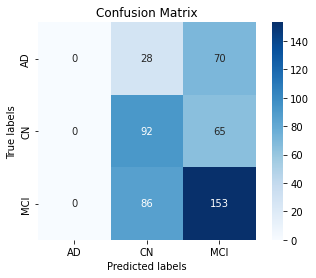

In [9]:
savepath = 'Augmentation training/Inception v3/Adam/Inception v3_100_0.0001/'
lr=0.0001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'inceptionv3_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model05 = inceptionv3_row(OPT, LOOS,METRICS,image_Shape)
history05 = model05.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model05 = inceptionv3_row(OPT, LOOS,METRICS,image_Shape)
model05.load_weights(glob.glob(f"{savepath}inceptionv3_row_10E-5_weights-epoch:*-val_Accuracy:{max(history05.history['val_Accuracy']):.4f}.h5")[0])
model05.save(f"{savepath}/inceptionv3_100_0.0001.h5")
p = model05.predict(testing_image_datagen)
predicted_lab = p.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save(f"{savepath}/inceptionv3_100_0.0001.npy",p )